In [3]:
# Add py_package path to system PYTHONPATH file

from sys import path

from os.path import expanduser as expanduser
from os.path import join as join

py_path = expanduser("~") 
for p in ["Documents", "CallCenterStaffing", "DataScripts", "py_package"]:
    py_path = join(py_path, p)

if py_path not in path:
    path.append(py_path)

In [25]:
    
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from importlib import reload
from sklearn import datasets, linear_model
from py_package import db_conn as db

conn_dict = { 
    "user"     : "szymonbocian",   \
    "password" : "",               \
    "host"     : "localhost",      \
    "port"     : "5432",           \
    "database" : "dwh_call_center"
}

lin_regr_sets_dict = {
    "train_year"     : 2019, \
    "test_year"      : 2019, \
    "train_set_week" : 11,   \
    "test_set_week"  : 12
}

db = db.DbConn(conn_dict)

train_X_sql_query = "SELECT sdh.* FROM snap.service_date_hour_vw sdh INNER JOIN tech.date_dim dd ON sdh.date_key = dd.date_key WHERE dd.iso_week_of_year = '%(train_set_week)s' AND dd.year_value = %(train_year)d;" % lin_regr_sets_dict
train_Y_sql_query = "SELECT sdh.* FROM snap.service_date_hour_vw sdh INNER JOIN tech.date_dim dd ON sdh.date_key = dd.date_key WHERE dd.iso_week_of_year = '%(test_set_week)s' AND dd.year_value = %(test_year)d;" % lin_regr_sets_dict

sql_dict = {
    "set_X"        : train_X_sql_query,
    "sets_columns" : "SELECT column_name FROM INFORMATION_SCHEMA.columns WHERE table_schema = 'snap' AND table_name = 'service_date_hour_vw';",
    "set_Y"        : train_Y_sql_query
}

col = [t[0] for t in db.run_sql(sql_dict["sets_columns"])]
# training sets
train_X_df = pd.DataFrame(db.run_sql(sql_dict["set_X"]), columns = col)
train_Y_df = pd.DataFrame(db.run_sql(sql_dict["set_Y"]), columns = col)
# testing sets
test_X_df = pd.DataFrame(db.run_sql(sql_dict["set_X"]), columns = col)
test_Y_df = pd.DataFrame(db.run_sql(sql_dict["set_Y"]), columns = col)

a = pd.DataFrame(db.run_sql("SELECT DISTINCT date_key from snap.service_date_hour_vw;"))

train_X_df["shift"] = train_X_df.apply(lambda x: "1" if x.hour_key < 16 else "2", axis = 1)
train_Y_df["shift"] = train_Y_df.apply(lambda x: "1" if x.hour_key < 16 else "2", axis = 1)

train_X_df.head(1)
train_Y_df.head(1)
a

,0
0,20190304
1,20190305
2,20190306
3,20190307
4,20190308
5,20190309
6,20190310
7,20190311
8,20190312
9,20190313


In [9]:
# adjust train to test or test to train sets depends on both sets size
if train_X_df["total_call"].size > train_Y_df["total_call"].size:
    l_size = train_Y_df["total_call"].size
else:
    l_size = train_X_df["total_call"].size
    
total_call_num_X = train_X_df["total_call"][:l_size]
total_call_num_Y = train_Y_df["total_call"][:l_size]

print(l_size, total_call_num_X.size, total_call_num_Y.size)

907 907 907


Coefficients: 
 [[0.77109915]]
Residual sum of squares: 729.60
Variance score: 0.54


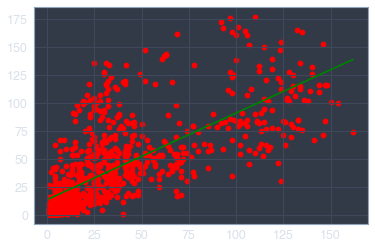

In [17]:
# linear regresion implementation

# total_call_num_X = train_X_df["total_call"] 
# total_call_num_Y = test_Y_df["total_call"]

total_call_num_X_train = total_call_num_X.values.reshape(-1, 1)
total_call_num_Y_train = total_call_num_Y.values.reshape(-1, 1)

total_call_num_X_test = total_call_num_X.values.reshape(-1, 1)
total_call_num_Y_test = total_call_num_Y.values.reshape(-1, 1)

regr = linear_model.LinearRegression()

regr.fit(total_call_num_X_train, total_call_num_Y_train)

# The coefficients
print('Coefficients: \n', regr.coef_)
# The mean square error
print("Residual sum of squares: %.2f"
      % np.mean((regr.predict(total_call_num_X_test) - total_call_num_Y_test) ** 2))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % regr.score(total_call_num_X_test, total_call_num_Y_test))

plt.scatter(total_call_num_X_test, total_call_num_Y_test, color = 'red')
plt.plot(total_call_num_X_test, regr.predict(total_call_num_X_test), color = 'green')


In [24]:
Y_predicted = regr.predict(total_call_num_X_test)
Y_predicted
#total_call_num_X_train

array([  2045.26825099,   2045.26825099,   1414.73162404,    784.19499709,
         3936.87813183,    784.19499709,   1414.73162404,   2045.26825099,
         2675.80487793,   3936.87813183,  10242.2444013 ,   6459.02463962,
         7720.09789351,   3306.34150488,   8350.63452046,   3936.87813183,
         4567.41475878,   5828.48801267,   8981.17114741,  14656.00078993,
        17178.14729772,  12133.85428214,  11503.3176552 ,  10872.78102825,
        10872.78102825,  14025.46416298,  20330.83043246,  11503.3176552 ,
        15917.07404383,  22222.4403133 ,  31680.48971751,  19700.29380551,
        17808.68392467,  18439.22055161,  16547.61067077,  15917.07404383,
        20961.3670594 ,  26636.19670193,  20330.83043246,  22852.97694024,
        24114.05019414,  26636.19670193,  22852.97694024,  28527.80658277,
        21591.90368635,  31680.48971751,  29158.34320972,  26005.66007498,
        28527.80658277,  28527.80658277,  24114.05019414,  25375.12344803,
        24744.58682109,  

In [27]:
from sklearn import datasets
diabetes = datasets.load_diabetes()

diabetes

# f, axarr = plt.subplots(5,2, sharex=True, sharey=True,figsize=(12,12))
# for i in range(0,5):
#     for j in range(0,2):
#         # Use only one feature
#         diabetes_X = diabetes.data[:, np.newaxis, i*2+j]
        
#         # Split the data into training/testing sets
#         diabetes_X_train = diabetes_X[:-20]
#         diabetes_X_test = diabetes_X[-20:]
        
#         # Split the targets into training/testing sets
#         diabetes_y_train = diabetes.target[:-20]
#         diabetes_y_test = diabetes.target[-20:]
        
#         # Create linear regression object
#         regr = linear_model.LinearRegression()
        
#         # Train the model using the training sets
#         regr.fit(diabetes_X_train, diabetes_y_train)
        
#         # The coefficients
#         print('Coefficients: \n', regr.coef_)
#         # The mean square error
#         print("Residual sum of squares: %.2f"
#               % np.mean((regr.predict(diabetes_X_test) - diabetes_y_test) ** 2))
#         # Explained variance score: 1 is perfect prediction
#         print('Variance score: %.2f' % regr.score(diabetes_X_test, diabetes_y_test))
        
#         # Plot outputs
#         axarr[i,j].scatter(diabetes_X_test, diabetes_y_test,  color='red')
#         axarr[i,j].plot(diabetes_X_test, regr.predict(diabetes_X_test), color='blue', linewidth=1)
        
# plt.show()

{'data': array([[ 0.03807591,  0.05068012,  0.06169621, ..., -0.00259226,
          0.01990842, -0.01764613],
        [-0.00188202, -0.04464164, -0.05147406, ..., -0.03949338,
         -0.06832974, -0.09220405],
        [ 0.08529891,  0.05068012,  0.04445121, ..., -0.00259226,
          0.00286377, -0.02593034],
        ...,
        [ 0.04170844,  0.05068012, -0.01590626, ..., -0.01107952,
         -0.04687948,  0.01549073],
        [-0.04547248, -0.04464164,  0.03906215, ...,  0.02655962,
          0.04452837, -0.02593034],
        [-0.04547248, -0.04464164, -0.0730303 , ..., -0.03949338,
         -0.00421986,  0.00306441]]),
 'target': array([151.,  75., 141., 206., 135.,  97., 138.,  63., 110., 310., 101.,
         69., 179., 185., 118., 171., 166., 144.,  97., 168.,  68.,  49.,
         68., 245., 184., 202., 137.,  85., 131., 283., 129.,  59., 341.,
         87.,  65., 102., 265., 276., 252.,  90., 100.,  55.,  61.,  92.,
        259.,  53., 190., 142.,  75., 142., 155., 225.,  59